# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import gc

In [2]:
import boto3
import os

In [3]:
import numpy as np
import pandas as pd
import scipy

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.preprocessing import LabelEncoder, normalize

from implicit.als import AlternatingLeastSquares

/home/mle-user/mle_projects_final/mle-project-sprint-4-v001/.env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from dotenv import load_dotenv
load_dotenv()

True

Самописные утилиты

In [7]:
def show_dtypes(df: pd.DataFrame, samples:int = 3) -> pd.DataFrame:
    return pd.merge(
        df.dtypes.astype(str).to_frame(name="type").reset_index().sort_values("type"),
        df.isna().sum().to_frame(name="isna").reset_index()
    ).merge(
        df.head(samples).T.reset_index()
    )

---

Отсюда можно выполнить код:
- последовательно Этап 1 и Этап 2
- сразу перейти к Этап 3

---

# === ЭТАП 1 ===

## Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [8]:
# 30 sec

df_tracks = pd.read_parquet("tracks.parquet")
print("'tracks.parquet' loaded")
df_catalog = pd.read_parquet("catalog_names.parquet")
print("'catalog_names.parquet' loaded")
df_events = pd.read_parquet("interactions.parquet")
print("'interactions.parquet' loaded")

'tracks.parquet' loaded
'catalog_names.parquet' loaded
'interactions.parquet' loaded


## Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

### Данные о треках

In [9]:
# Размер таблицы
# (1000000, 4)

df_tracks.shape

(1000000, 4)

In [10]:
# Пропуски, Типы, Примеры данных

show_dtypes(df_tracks, 5)

,index,type,isna,0,1,2,3,4
0,track_id,int64,0,26,38,135,136,138
1,albums,object,0,"[3, 2490753]","[3, 2490753]","[12, 214, 2490809]","[12, 214, 2490809]","[12, 214, 322, 72275, 72292, 91199, 213505, 24..."
2,artists,object,0,[16],[16],[84],[84],[84]
3,genres,object,0,"[11, 21]","[11, 21]",[11],[11],[11]


In [11]:
# Кол-во уникальных треков
# 1000000

df_tracks["track_id"].nunique()

1000000

In [12]:
# Индексы треков
# (True, 26, 101521819)

df_tracks["track_id"].is_monotonic_increasing, df_tracks["track_id"].min(), df_tracks["track_id"].max()

(True, 26, 101521819)

In [13]:
# 2 min !
# Дубликаты
# 0

df_tracks.astype(str).duplicated().sum()

0

### Имена исполнителей, названия альбомов, треков и жанров

In [14]:
# Размер таблицы
# (1812471, 3)

df_catalog.shape

(1812471, 3)

In [15]:
# Пропуски, Типы, Примеры данных

show_dtypes(df_catalog, 5)

,index,type,isna,0,1,2,3,4
0,id,int64,0,3,12,13,17,26
1,type,object,0,album,album,album,album,album
2,name,object,0,Taller Children,Wild Young Hearts,Lonesome Crow,Graffiti Soul,Blues Six Pack


In [16]:
# Кол-во уникальных значений
# id      1776697
# type          4
# name     945118

df_catalog.nunique()

id      1776697
type          4
name     945118
dtype: int64

In [17]:
# Типы
# ['album', 'artist', 'genre', 'track']

df_catalog["type"].unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [18]:
# Дубликаты
# 0

df_catalog.duplicated().sum()

0

### Данные о том, какие пользователи прослушали тот или иной трек

In [19]:
# Размер таблицы
# (222629898, 4)

df_events.shape

(222629898, 4)

In [20]:
# Пропуски, Типы, Примеры данных

show_dtypes(df_events, 5)

,index,type,isna,0,1,2,3,4
0,started_at,datetime64[ns],0,2022-07-17 00:00:00,2022-07-19 00:00:00,2022-07-21 00:00:00,2022-07-22 00:00:00,2022-07-22 00:00:00
1,track_seq,int16,0,1,2,3,4,5
2,user_id,int32,0,0,0,0,0,0
3,track_id,int32,0,99262,589498,590262,590303,590692


In [21]:
# Кол-во уникальных значений
# user_id       1373221
# track_id      1000000
# track_seq       16637
# started_at        365

df_events.nunique()

user_id       1373221
track_id      1000000
track_seq       16637
started_at        365
dtype: int64

: 

In [22]:
# 2 min !
# Дубликаты
# 0

df_events.duplicated().sum()

## Выводы


- Пропуски в данных отсутствуют
- Дубликаты отсутствуют
- Типы данных соответствуют
- Полный размер матрицы взаимодействий:
  - **1 373 221** пользователей
  - **1 000 000** треков
- При подготовке данных переименовать `track_id` в общепринятое обозначение объектов взаимодействия `item_id`

# === ЭТАП 2 ===

## EDA

Информация по названиям треков и исполнителям

In [ ]:
# 2 min !

df_track_info = (
    df_tracks
    .merge(
        df_catalog.loc[df_catalog["type"]=="track", ["id", "name"]].rename(columns={"id": "track_id", "name": "track_name"}),
        on="track_id",
        how="left",
    )
    .merge(
        (
            df_tracks[["track_id", "artists"]]
            .explode("artists")
            .merge(
                df_catalog.loc[df_catalog["type"]=="artist", ["id", "name"]].rename(columns={"id": "artists", "name": "artist_names"}),
                on="artists",
                how="left"
            )
            .groupby("track_id", as_index=False)["artist_names"].apply(lambda x: '; '.join(x.astype(str)))
        ),
        on="track_id",
        how="left",
    )
    [["track_id", "track_name", "artist_names"]]
)

In [ ]:
# (1000000, 3)
df_track_info.shape

(1000000, 3)

In [ ]:
df_track_info.head()

,track_id,track_name,artist_names
0,26,Complimentary Me,Elizabeth & the Catapult
1,38,Momma's Boy,Elizabeth & the Catapult
2,135,Atticus,Noisettes
3,136,24 Hours,Noisettes
4,138,Don't Upset The Rhythm (Go Baby Go),Noisettes


### Каталог

In [ ]:
# album      658724
# artist     153581
# genre         166
# track     1000000

df_catalog.groupby("type")["id"].nunique()

type
album      658724
artist     153581
genre         166
track     1000000
Name: id, dtype: int64

In [ ]:
# 658724

df_tracks["albums"].explode().nunique()

658724

In [ ]:
# 153581

df_tracks["artists"].explode().nunique()

153581

In [ ]:
# 173

df_tracks["genres"].explode().nunique()

173

In [ ]:
set(df_tracks["track_id"].explode()) ^ set(df_catalog.loc[df_catalog["type"]=="track", "id"])

set()

In [ ]:
set(df_tracks["albums"].explode()) ^ set(df_catalog.loc[df_catalog["type"]=="album", "id"])

{nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan}

In [ ]:
(df_tracks["albums"].apply(len) == 0).sum()

18

In [ ]:
set(df_tracks["artists"].explode()) ^ set(df_catalog.loc[df_catalog["type"]=="artist", "id"])

{nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [ ]:
(df_tracks["artists"].apply(len) == 0).sum()

15369

In [ ]:
set(df_tracks["genres"].explode()) ^ set(df_catalog.loc[df_catalog["type"]=="getnre", "id"])

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 nan,
 35,
 nan,
 37,
 38,
 39,
 40,
 41,
 nan,
 43,
 44,
 45,
 nan,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 nan,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 nan,
 nan,
 73,
 74,
 75,
 76,
 77,
 nan,
 71,
 80,
 72,
 79,
 nan,
 nan,
 85,
 86,
 nan,
 88,
 89,
 nan,
 90,
 92,
 nan,
 94,
 95,
 nan,
 97,
 98,
 99,
 nan,
 101,
 102,
 nan,
 104,
 nan,
 nan,
 105,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 nan,
 120,
 121,
 122,
 123,
 124,
 nan,
 126,
 127,
 128,
 nan,
 130,
 nan,
 132,
 133,
 134,
 nan,
 nan,
 131,
 138,
 nan,
 135,
 nan,
 nan,
 nan,
 nan,
 146,
 nan,
 148,
 nan,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 nan,
 167,
 168,
 169,
 nan,
 nan,
 166,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 n

In [ ]:
(df_tracks["genres"].apply(len) == 0).sum()

3687

**Выводы:**
- Кол-во треков в каталоге соответствует кол-ву треков в данных
- Альбомы в каталоге соответствует альбомам в данных по трекам
- Испольнители в каталоге соответствует исполнителям в данных по трекам
- ***Жанров в данных по трекам больше, чем в каталоге***
- В данных по треакам имеется ***18 треков без альбома***
- В данных по треакам имеется ***15369 треков без исполнителя***
- В данных по треакам имеется ***3687 треков без жанра***


**Выводы 2:**
- При построении персональных рекомендации моделью ALS на ВМ умирает ядро. После 10 часов тщетных попыток построить рекомендации решение сократить матрицу:
  - Удаляме треки без альбомов
  - Удаляем треки без исполнителя
  - Удаляме треки без жанра

### Временной период в данных

In [ ]:
# (Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-31 00:00:00'))

df_events["started_at"].min(), df_events["started_at"].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-31 00:00:00'))

#### События по дням

In [ ]:
# 2 min !

interactions_by_day = df_events.groupby("started_at", as_index=False).agg(
    n_events=("started_at", "count"),
    n_users=("user_id", "nunique"),
    n_items=("track_id", "nunique"),
)

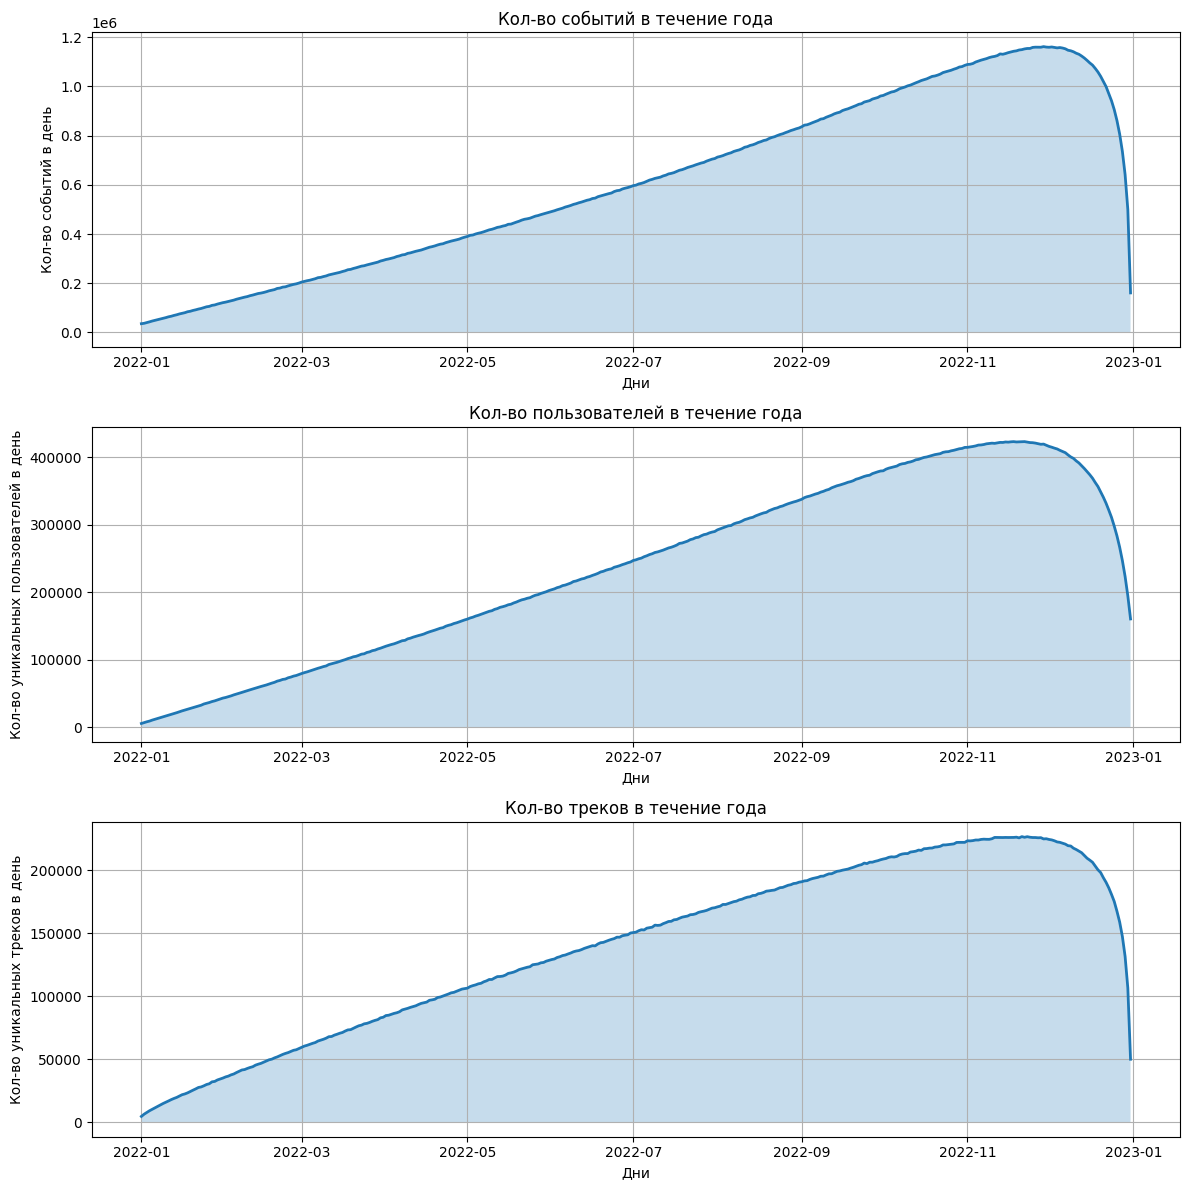

In [ ]:
# распределение взаимодействий по дням

fig, axs = plt.subplots(3, 1, figsize=(12, 12))

axs[0].plot(interactions_by_day["started_at"], interactions_by_day["n_events"], linewidth=2)
axs[0].fill_between(interactions_by_day["started_at"], [0]*interactions_by_day.shape[0], interactions_by_day["n_events"], alpha=0.25)
axs[0].set_title("Кол-во событий в течение года")
axs[0].set_ylabel("Кол-во событий в день")
axs[0].set_xlabel("Дни")

axs[1].plot(interactions_by_day["started_at"], interactions_by_day["n_users"], linewidth=2)
axs[1].fill_between(interactions_by_day["started_at"], [0]*interactions_by_day.shape[0], interactions_by_day["n_users"], alpha=0.25)
axs[1].set_title("Кол-во пользователей в течение года")
axs[1].set_ylabel("Кол-во уникальных пользователей в день")
axs[1].set_xlabel("Дни")

axs[2].plot(interactions_by_day["started_at"], interactions_by_day["n_items"], linewidth=2)
axs[2].fill_between(interactions_by_day["started_at"], [0]*interactions_by_day.shape[0], interactions_by_day["n_items"], alpha=0.25)
axs[2].set_title("Кол-во треков в течение года")
axs[2].set_ylabel("Кол-во уникальных треков в день")
axs[2].set_xlabel("Дни")

for ax in axs:
    ax.grid("both")

fig.tight_layout()

In [ ]:
# Если взять в тест декабрь

df_test_temp = df_events[df_events["started_at"]>="2022-12-01"]
print("Кол-во клиентов в тесте:")
print(df_test_temp["user_id"].nunique())
print("Доля клиентов в тесте, которая есть в трейне:")
print(f'{df_events.loc[df_events["started_at"]<"2022-12-01", "user_id"].drop_duplicates().isin(df_test_temp["user_id"]).sum() / df_test_temp["user_id"].nunique():.2%}')

Кол-во клиентов в тесте:
995485
Доля клиентов в тесте, которая есть в трейне:
92.14%


In [ ]:
# Если взять в тест ноябрь

df_test_temp = df_events[(df_events["started_at"]>="2022-11-01") & (df_events["started_at"]<"2022-12-01")]
print("Кол-во клиентов в тесте:")
print(df_test_temp["user_id"].nunique())
print("Доля клиентов в тесте, которая есть в трейне:")
print(f'{df_events.loc[df_events["started_at"]<"2022-11-01", "user_id"].drop_duplicates().isin(df_test_temp["user_id"]).sum() / df_test_temp["user_id"].nunique():.2%}')

Кол-во клиентов в тесте:
1081320
Доля клиентов в тесте, которая есть в трейне:
90.16%


In [ ]:
del interactions_by_day, df_test_temp
gc.collect()

0

In [ ]:
# 1.062882386952999

(1081320 * 0.9016) / (995485 * 0.9214)

1.062882386952999

**Выводы:**
- Имеем данные о взаимодйствиях пользоватлей за период всего 2022 года (365 дней)
- До декабря наблюдается линейный рост кол-ва уникальных клиентов, а с конца ноября - начала декабря наблюдается спад кол-ва уникальных пользователей и соответственно уникальных треков и событий взаимодействия пользователей с треками
- Если взять в тест ноябрь, то кол-во оцениваемых клиентов на тесте больше на 6%, при этом потеряем ценную историю взаимодействий в 1 месяц. Поэтому в тест лучше брать период декабря

### Распределение количества прослушанных треков.

In [ ]:
# 2 min

users_tracks = (
    df_events.groupby("user_id")
    .agg(
        n_tracks = ("track_id", "nunique"),
        max_seq = ("track_seq", "max"),
        min_date = ("started_at", "min"),
        max_date = ("started_at", "max"),
    )
)

In [ ]:
users_tracks.head()

NameError: name 'users_tracks' is not defined

In [ ]:
# Проверка: соответствует ли последовательность прослушивания треков кол-ву прслушанных треков

assert all(users_tracks["n_tracks"] == users_tracks["max_seq"])

In [47]:
users_tracks["n_tracks"].describe().to_frame().style.format('{:.1f}')

,n_tracks
count,1373221.0
mean,162.1
std,351.3
min,1.0
25%,23.0
50%,55.0
75%,154.0
max,16637.0


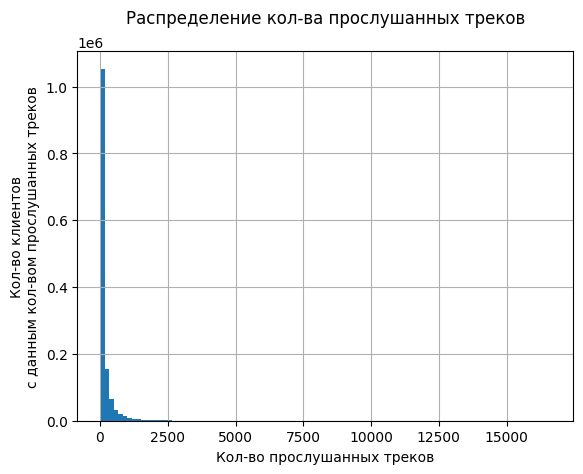

In [48]:
users_tracks["n_tracks"].hist(bins=100)

plt.title("Распределение кол-ва прослушанных треков", pad=20)
plt.xlabel("Кол-во прослушанных треков")
plt.ylabel("Кол-во клиентов\nс данным кол-вом прослушанных треков")
plt.show()

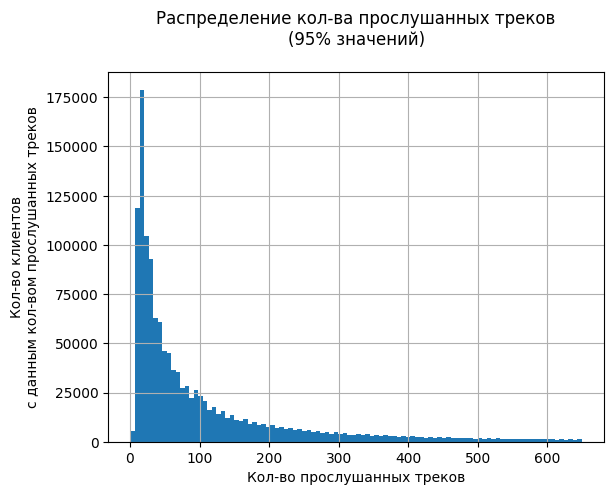

In [49]:
users_tracks.loc[users_tracks["n_tracks"] < users_tracks["n_tracks"].quantile(0.95), "n_tracks"].hist(bins=100)

plt.title("Распределение кол-ва прослушанных треков\n(95% значений)", pad=20)
plt.xlabel("Кол-во прослушанных треков")
plt.ylabel("Кол-во клиентов\nс данным кол-вом прослушанных треков")
plt.show()

In [50]:
pd.concat([
    users_tracks["n_tracks"].value_counts(normalize=True).sort_index().head(20),
    users_tracks["n_tracks"].value_counts(normalize=True).sort_index().head(20).cumsum(),
], axis=1)

,proportion,proportion
n_tracks,,
1,0.000618,0.000618
2,0.000531,0.001149
3,0.000484,0.001633
4,0.000509,0.002142
5,0.000492,0.002634
6,0.000610,0.003243
7,0.000695,0.003939
8,0.000936,0.004875
9,0.001462,0.006337


In [ ]:
pd.concat([
    users_tracks["n_tracks"].value_counts(normalize=True, ascending=False).sort_index().head(20),
    users_tracks["n_tracks"].value_counts(normalize=True, ascending=False).sort_index().head(20).cumsum(),
], axis=1)

,proportion,proportion
n_tracks,,
1,0.000618,0.000618
2,0.000531,0.001149
3,0.000484,0.001633
4,0.000509,0.002142
5,0.000492,0.002634
6,0.000610,0.003243
7,0.000695,0.003939
8,0.000936,0.004875
9,0.001462,0.006337


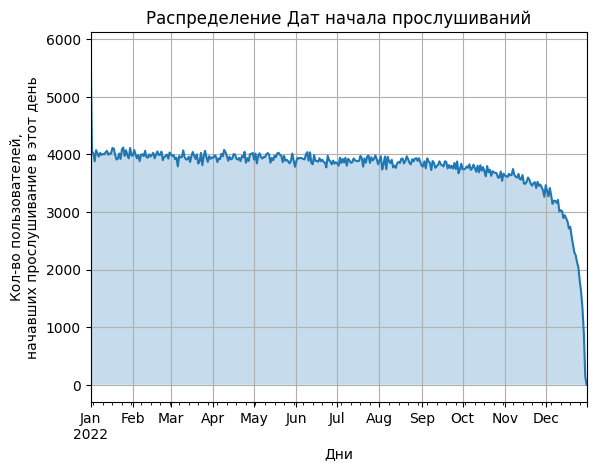

In [51]:
df_plot = users_tracks["min_date"].value_counts().sort_index()
df_plot.plot()
plt.fill_between(df_plot.index, [0]*df_plot.shape[0], df_plot, alpha=0.25)

plt.grid("both")
plt.title("Распределение Дат начала прослушиваний")
plt.ylabel("Кол-во пользователей,\nначавших прослушивание в этот день")
plt.xlabel("Дни")
plt.show()

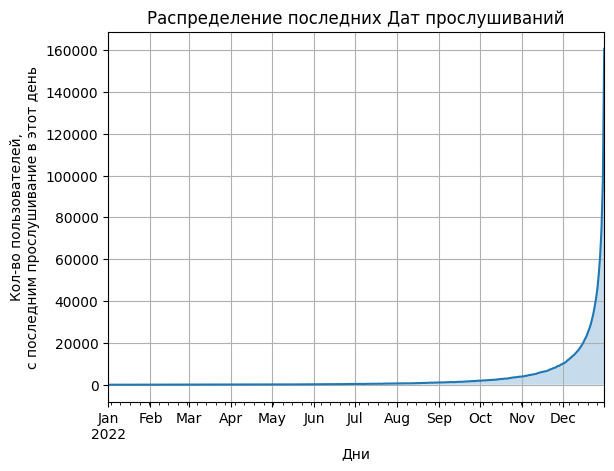

In [52]:
df_plot = users_tracks["max_date"].value_counts().sort_index()
df_plot.plot()
plt.fill_between(df_plot.index, [0]*df_plot.shape[0], df_plot, alpha=0.25)

plt.grid("both")
plt.title("Распределение последних Дат прослушиваний")
plt.ylabel("Кол-во пользователей,\nс последним прослушивание в этот день")
plt.xlabel("Дни")
plt.show()

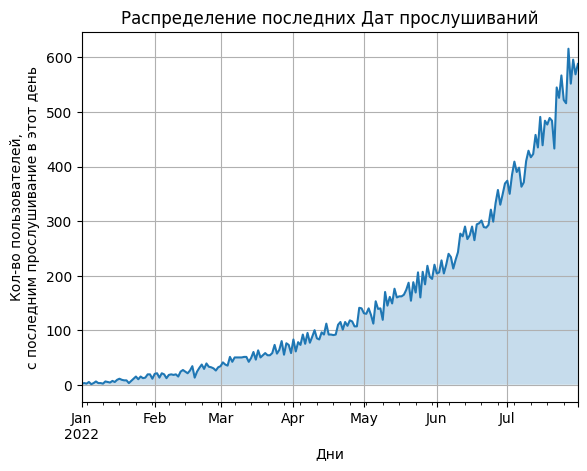

In [53]:
df_plot = users_tracks.loc[users_tracks["max_date"] < '2022-08-01', "max_date"].value_counts().sort_index()
df_plot.plot()
plt.fill_between(df_plot.index, [0]*df_plot.shape[0], df_plot, alpha=0.25)

plt.grid("both")
plt.title("Распределение последних Дат прослушиваний")
plt.ylabel("Кол-во пользователей,\nс последним прослушивание в этот день")
plt.xlabel("Дни")
plt.show()

In [54]:
del df_plot, users_tracks
gc.collect()

43962

**Выводы:**
- Пользователи не слушают треки повторно (оценки по кол-ву прослушиваний одного трека не построить)
- В среднем пользователи прослушивают 162 трека за год
- Медиана прослушиваний за год = 55 треков
- Минимум прослешиваний за год = 1 трек
- Максимум прослушиваний за год = 16 637 треков
- 10 и менее прослушанных треков имеют менее 1% пользователей - можно отбросить этих пользователей
- до ноября стабильно ежедневно присоединяются к сервису поярдка 4000 новых пользователей, затем идет резкое снижение новых пользователей

**Выводы 2:**
- При построении персональных рекомендации моделью ALS на ВМ умирает ядро. После 10 часов тщетных попыток построить рекомендации решение сократить матрицу:
  - Оставляем клиентов с количеством прослушанных треков не менее 10 и не более 500. Т.е. обрежем выбросы.

### Наиболее популярные треки

In [55]:
# 2 min

pop_tracks = df_events.groupby("track_id", as_index=False).agg(n_users=("user_id", "nunique"))

In [56]:
pop_tracks["pop_rating"] = pop_tracks["n_users"] / df_events["user_id"].nunique()

In [57]:
# (1000000, 3)

pop_tracks.shape

(1000000, 3)

In [58]:
pop_tracks.head()

,track_id,n_users,pop_rating
0,26,5,0.000004
1,38,8,0.000006
2,135,16,0.000012
3,136,7,0.000005
4,138,17,0.000012


Рассмотрим 20 наиболее популярных треков

In [59]:
pop_tracks.sort_values("n_users", ascending=False).head(20).merge(df_track_info)

,track_id,n_users,pop_rating,track_name,artist_names
0,53404,111062,0.080877,Smells Like Teen Spirit,Nirvana
1,33311009,106921,0.077861,Believer,Imagine Dragons
2,178529,101924,0.074223,Numb,Linkin Park
3,35505245,99490,0.072450,I Got Love,Miyagi & Эндшпиль; Рем Дигга
4,65851540,86670,0.063114,Юность,Dabro
5,24692821,86246,0.062806,Way Down We Go,KALEO
6,32947997,85886,0.062543,Shape of You,Ed Sheeran
7,51241318,85244,0.062076,In The End,Tommee Profitt; Fleurie; Mellen Gi
8,795836,85042,0.061929,Shape Of My Heart,Sting
9,45499814,84748,0.061715,Life,Zivert


In [65]:
pd.concat([
    pop_tracks["n_users"].value_counts(normalize=True).sort_index().head(20),
    pop_tracks["n_users"].value_counts(normalize=True).sort_index().head(20).cumsum(),
], axis=1)

,proportion,proportion
n_users,,
5,0.053790,0.053790
6,0.078428,0.132218
7,0.061507,0.193725
8,0.050066,0.243791
9,0.041822,0.285613
10,0.035885,0.321498
11,0.031282,0.352780
12,0.027301,0.380081
13,0.024535,0.404616


In [63]:
pop_tracks["n_users"].min()

5

In [58]:
# del pop_tracks  # пригодится на поиске наиболее популярных жанров и исполнителей
# gc.collect()

**Вывод:**
- Наиболее популярные треки:
  - Nirvana "Smells Like Teen Spirit"
  - Imagine Dragons "Believer"
  - Linkin Park "Numb"

**Выводы 2:**
- При построении персональных рекомендации моделью ALS на ВМ умирает ядро. После 10 часов тщетных попыток построить рекомендации решение сократить матрицу:
  - Удаляем треки, которые прослушивали менее 10 раз

### Наиболее популярные жанры

In [66]:
# Ядро падает:

# pop_genres = (
#     df_events[["track_id"]]
#     .merge(
#         df_tracks[["track_id", "genres"]].explode("genres"),
#         on="track_id",
#         how="left",
#     )
#     ["genres"].value_counts()
# )

In [67]:
pop_genres = (
    pop_tracks[["track_id", "n_users"]]
    .merge(
        df_tracks[["track_id", "genres"]].explode("genres"),
        on="track_id",
        how="left",
    )
    .groupby("genres", as_index=False)["n_users"].sum()
)

In [68]:
pop_genres["pop_rating"] = pop_genres["n_users"] / pop_genres["n_users"].sum()

In [69]:
# (173, 3)

pop_genres.shape

(173, 3)

In [70]:
pop_genres.head()

,genres,n_users,pop_rating
0,1,103086,0.000274
1,2,13166147,0.034965
2,3,25303695,0.067198
3,4,213528,0.000567
4,5,774668,0.002057


In [71]:
pop_genres.tail()

,genres,n_users,pop_rating
168,1016,228315,0.000606
169,1182,35013,0.000093
170,1197,137301,0.000365
171,1484,57787,0.000153
172,1542,9881,0.000026


Рассмотрим 20 наиболее популярных жанров

In [72]:
(
    pop_genres
    .sort_values("n_users", ascending=False)
    .head(20)
    .merge(
        df_catalog.loc[df_catalog["type"]=="genre", ["id", "name"]].rename(columns={"id": "genres", "name": "genre_name"}),
        on="genres",
        how="left",
    )
)

,genres,n_users,pop_rating,genre_name
0,11,55578312,0.147597,pop
1,75,37799821,0.100383,rap
2,102,31092013,0.082570,allrock
3,20,26626241,0.070710,ruspop
4,3,25303695,0.067198,rusrap
5,68,20120981,0.053434,electronics
6,16,16291557,0.043265,dance
7,2,13166147,0.034965,rusrock
8,14,12772644,0.033920,rock
9,47,12437375,0.033029,metal


In [73]:
del pop_genres
gc.collect()

0

**Вывод:**
- Наиболее популярные жарны:
  - Поп
  - Рэп
  - allrock

### Наиболее популярные исполнители

In [74]:
pop_artists = (
    pop_tracks[["track_id", "n_users"]]
    .merge(
        df_tracks[["track_id", "artists"]].explode("artists"),
        on="track_id",
        how="left",
    )
    .groupby("artists", as_index=False)["n_users"].sum()
)

In [75]:
pop_artists["pop_rating"] = pop_artists["n_users"] / pop_artists["n_users"].sum()

In [76]:
# (153581, 3)

pop_artists.shape

(153581, 3)

In [77]:
pop_artists.head()

,artists,n_users,pop_rating
0,4,39,1.366340e-07
1,5,164,5.745633e-07
2,7,7,2.452404e-08
3,9,73794,2.585325e-04
4,12,5,1.751717e-08


Рассмотрим 20 наиболее популярных исполнителей

In [78]:
(
    pop_artists
    .sort_values("n_users", ascending=False)
    .head(20)
    .merge(
        df_catalog.loc[df_catalog["type"]=="artist", ["id", "name"]].rename(columns={"id": "artists", "name": "artist_name"}),
        on="artists",
        how="left",
    )
)

,artists,n_users,pop_rating,artist_name
0,41191,886086,0.003104,Баста
1,41114,831788,0.002914,Би-2
2,3246342,828217,0.002902,Скриптонит
3,675068,804918,0.002820,Imagine Dragons
4,41075,795072,0.002785,КИНО
5,41052,748064,0.002621,Король и Шут
6,975699,717773,0.002515,Макс Корж
7,4611844,677548,0.002374,Miyagi & Эндшпиль
8,666984,676222,0.002369,Artik & Asti
9,36800,675728,0.002367,Linkin Park


In [79]:
del pop_artists
gc.collect()

0

**Вывод:**
- Наиболее популярные исполнители:
  - Баста
  - Би-2
  - Скриптонит

### Треки, которые никто не прослушал

In [80]:
# 1000000

df_events["track_id"].nunique()

1000000

In [81]:
# empty DataFrame

df_tracks.loc[~df_tracks["track_id"].isin(df_events["track_id"].unique())]

,track_id,albums,artists,genres


**Вывод:**
- Треков, которые никто не прослушал нет в данных

## Преобразование данных

In [82]:
# 222629898

shape_origin = df_events.shape[0]
shape_origin

222629898

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [83]:
# Добавим наименования к данным по трекам

df_tracks = df_tracks.merge(
    df_track_info,
    on="track_id",
    how="left",
)

In [85]:
# Оставим клиентов с более 15 прослушанными треками

# Падает ядро:
# df_events.groupby("user_id").filter(lambda x: x["track_seq"].max() > 10)

df_events = df_events.loc[df_events["user_id"].isin(
    df_events.loc[df_events["track_seq"] > 15, "user_id"].unique()
)]

In [89]:
# Удаляем треки без жанра, исполнителя или альбома

df_tracks = df_tracks[df_tracks["albums"].apply(len) > 0]
df_tracks = df_tracks[df_tracks["artists"].apply(len) > 0]
df_tracks = df_tracks[df_tracks["genres"].apply(len) > 0]

In [92]:
# Оставляем треки, которые прослушивали не менее 10 раз

df_tracks = df_tracks[df_tracks["track_id"].isin(
    pop_tracks.loc[pop_tracks["n_users"] >= 10, "track_id"]
)]

In [93]:
df_events = df_events[df_events["track_id"].isin(df_tracks["track_id"])]

In [94]:
# Переименуем колонки

df_events = df_events.rename(columns={
    "track_id": "item_id_origin",
    "track_seq": "item_seq",
    "user_id": "user_id_origin",
})
df_tracks = df_tracks.rename(columns={
    "track_id": "item_id_origin",
})

In [95]:
# 2 min !
# Преобразуем идентификаторы пользователей и товаров в непрерывную последовательность

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df_events["user_id"] = user_encoder.fit_transform(df_events["user_id_origin"])

item_encoder.fit(df_tracks["item_id_origin"])
df_tracks["item_id"] = item_encoder.transform(df_tracks["item_id_origin"])
df_events["item_id"] = item_encoder.transform(df_events["item_id_origin"])

In [96]:
# Добавим рейтинги
# Поскольку пользователи не прослушивали трек дважды, то все оценки = 1 (см. ### Распределение количества прослушанных треков.)

df_events["ratings"] = 1

In [97]:
pd.concat([
    df_tracks.head(),
    df_tracks.tail()
])

,item_id_origin,albums,artists,genres,track_name,artist_names,item_id
2,135,"[12, 214, 2490809]",[84],[11],Atticus,Noisettes,0
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),Noisettes,1
6,140,"[12, 214, 2490809]",[84],[11],Sometimes,Noisettes,2
7,141,"[12, 214, 60093, 2490809, 10023160, 15635235, ...",[84],[11],Never Forget You,Noisettes,3
8,143,"[12, 214, 2490809]",[84],[11],Every Now And Then,Noisettes,4
999993,101458360,[21394533],"[314001, 40324, 7237963]",[13],KULT,grandson; Steve Aoki; Jasiah,703754
999994,101476180,[21399110],[6207325],"[11, 20]",Февраль,Gafur,703755
999996,101490148,[21403052],[9078726],"[11, 20]",Без капли мысли,Даня Милохин,703756
999998,101495927,[21404975],[4462686],"[3, 75]",Москва,Yanix,703757
999999,101521819,[21414638],[5056591],"[3, 75]",Вокзал,Джарахов,703758


In [98]:
pd.concat([
    df_events.head(),
    df_events.tail()
])

,user_id_origin,item_id_origin,item_seq,started_at,user_id,item_id,ratings
0,0,99262,1,2022-07-17,0,12482,1
1,0,589498,2,2022-07-19,0,45093,1
2,0,590262,3,2022-07-21,0,45483,1
3,0,590303,4,2022-07-22,0,45503,1
4,0,590692,5,2022-07-22,0,45693,1
287,1374582,95514767,288,2022-12-29,1189048,695976,1
288,1374582,97220301,289,2022-12-29,1189048,698975,1
289,1374582,97241171,290,2022-12-29,1189048,699026,1
290,1374582,98542641,291,2022-12-29,1189048,700940,1
291,1374582,100736375,292,2022-12-30,1189048,703430,1


In [99]:
df_tracks.shape

(703759, 7)

In [100]:
df_events.shape[0] / shape_origin

0.979454017447378

**Вывод:**

- Данные преобразованы
- Потеря по событиям менее 3%

## Сохранение данных

Сохраним словари для декодированных идентификаторов

In [82]:
df_tracks[["item_id_origin", "item_id"]].reset_index(drop=True).to_parquet("id_dict_items.parquet")

In [83]:
df_events[["user_id_origin", "user_id"]].drop_duplicates().reset_index(drop=True).to_parquet("id_dict_users.parquet")

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [85]:
df_tracks[['item_id', 'albums', 'artists', 'genres', 'track_name', 'artist_names']].to_parquet("items.parquet")

In [86]:
# 1 min !

df_events[['user_id', 'item_id', 'item_seq', 'started_at', 'ratings']].to_parquet("events.parquet")

In [87]:
session = boto3.session.Session()
s3 = boto3.client(
    service_name = 's3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"))

bucket_name = os.getenv("S3_BUCKET_NAME")

In [88]:
s3.upload_file("items.parquet", bucket_name, "recsys/data/items.parquet")

In [89]:
s3.upload_file("events.parquet", bucket_name, "recsys/data/events.parquet")

In [90]:
# files = []
# sizes = []


# if s3.list_objects(Bucket=bucket_name).get('Contents'):
#     for key in s3.list_objects(Bucket=bucket_name)['Contents']:
#         cur_key = key['Key']
#         response = s3.head_object(Bucket = bucket_name, Key = cur_key)
#         cur_size = response['ContentLength']
#         print(f"file {cur_key} weights {cur_size} bytes")
#         files.append(cur_key)
#         sizes.append(cur_size)

# total_weight = sum(sizes)
# print(f"Total weight of all files in bucket = {total_weight}")

## Очистка памяти

- Cледует перезапустить kernel
- Выполнить раздел "# Инициализация" (т.е. все, что до раздела "# === ЭТАП 1 ===")

---

---

# === ЭТАП 3 ===

## Загрузка данных

Загружаем данные из файлов:
- items.parquet
- events.parquet
- catalog_names.parquet

In [ ]:
df_catalog = pd.read_parquet("catalog_names.parquet")
print("'catalog_names.parquet' loaded")

In [ ]:
df_items = pd.read_parquet("items.parquet")
print("'tracks.parquet' loaded")

In [4]:
# 1 min

df_events = pd.read_parquet("events.parquet")
print("'interactions.parquet' loaded")

'interactions.parquet' loaded


In [7]:
# (1812471, 3)

df_catalog.shape

(1812471, 3)

In [8]:
df_catalog.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [9]:
# (1000000, 6)

df_items.shape

(1000000, 6)

In [10]:
df_items.head()

,item_id,albums,artists,genres,track_name,artist_names
0,0,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,Elizabeth & the Catapult
1,1,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,Elizabeth & the Catapult
2,2,"[12, 214, 2490809]",[84],[11],Atticus,Noisettes
3,3,"[12, 214, 2490809]",[84],[11],24 Hours,Noisettes
4,4,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),Noisettes


In [11]:
# (222531295, 5)

df_events.shape

(222531295, 5)

In [12]:
df_events.head()

,user_id,item_id,item_seq,started_at,ratings
0,0,16078,1,2022-07-17,1
1,0,60661,2,2022-07-19,1
2,0,61135,3,2022-07-21,1
3,0,61158,4,2022-07-22,1
4,0,61386,5,2022-07-22,1


## Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

В тренировочную отнесем все данные до 16 декабря 2022 года (не включительно).

In [5]:
SPLIT_POINT_DATE = '2022-12-16'

In [6]:
df_events_train = df_events[df_events["started_at"] < SPLIT_POINT_DATE]
df_events_test = df_events[df_events["started_at"] >= SPLIT_POINT_DATE]

In [7]:
del df_events
gc.collect()

0

In [11]:
# Размеры выборок
# ((208 648 584, 5), (13 882 711, 5))

df_events_train.shape, df_events_test.shape

((208648584, 5), (13882711, 5))

In [12]:
# Кол-во клиентов в каждой выборке
# (1 329 662, 776 356)

df_events_train["user_id"].nunique(), df_events_test["user_id"].nunique()

(1329662, 776356)

In [13]:
# Клиенты в трейне и тесте
# (746306,)

common_users = np.intersect1d(df_events_train["user_id"].unique(), df_events_test["user_id"].unique())
common_users.shape

(746306,)

In [14]:
# "Холодные" пользователи
# (30050,)

cold_users = np.setdiff1d(df_events_test["user_id"].unique(), df_events_train["user_id"].unique())
cold_users.shape

(30050,)

---

## Топ популярных

Рассчитаем рекомендации как топ популярных.

Для выбора наиболее популярных примем актуальный период в 100 дней

Отберем топ-100 наиболее популярных треков

In [20]:
ACTUAL_N_DAYS = 100

In [21]:
# 30 sec

actual_start_date = df_events_train["started_at"].max() - pd.DateOffset(days=ACTUAL_N_DAYS)

df_items_popular = (
    df_events_train
    .loc[df_events_train["started_at"] >= actual_start_date, ["user_id", "item_id"]]
    .groupby("item_id", as_index=False).agg(score=("user_id", "nunique"))
    .sort_values("score", ascending=False)
    .head(100)
    .reset_index(drop=True)
)
df_items_popular["score"] /= df_items_popular["score"].max()

In [22]:
df_items_popular.head()

,item_id,score
0,779281,1.000000
1,829320,0.996666
2,483876,0.924520
3,696106,0.897710
4,699153,0.866444


In [23]:
# Рассмотрим наименованяи топ-20 треков

df_items_popular.merge(
    df_items[["item_id", "track_name", "artist_names"]]
).head(20)

,item_id,score,track_name,artist_names
0,779281,1.000000,Blinding Lights,The Weeknd
1,829320,0.996666,Юность,Dabro
2,483876,0.924520,Believer,Imagine Dragons
3,696106,0.897710,In The End,Tommee Profitt; Fleurie; Mellen Gi
4,699153,0.866444,bad guy,Billie Eilish
5,647237,0.829055,Life,Zivert
6,744014,0.824564,Dance Monkey,Tones And I
7,917171,0.803316,Rampampam,Minelli
8,940964,0.795965,Птичка,HammAli & Navai
9,757669,0.795772,Комета,JONY


### Сохранение

In [24]:
df_items_popular.to_parquet("top_popular.parquet")

---

## Персональные

Рассчитаем персональные рекомендации.

Ядро на ВМ постоянно умирает, поэтому этот раздел прогоняем отдельно

### Матрица взаимодействий

In [8]:
# создаём sparse-матрицу формата CSR

user_item_matrix_train = scipy.sparse.csr_matrix(
    (
        df_events_train["ratings"],
        (df_events_train['user_id'], df_events_train['item_id'])
    ),
    dtype=np.int8
) 

In [9]:
# <Compressed Sparse Row sparse matrix of dtype 'int8'
# 	with 208648584 stored elements and shape (1359712, 1000000)>

user_item_matrix_train

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 208648584 stored elements and shape (1359712, 1000000)>

### Обучение модели

In [10]:
# Создадим и обучим модель
# iterations=10 -> 10 min
# iterations=15 -> 15 min

als_model = AlternatingLeastSquares(factors=50, iterations=15, regularization=0.05, random_state=0)

als_model.fit(user_item_matrix_train) 

/home/mle-user/mle_projects_final/mle-project-sprint-4-v001/.env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 15/15 [14:33<00:00, 58.25s/it]


In [11]:
def get_recommendations_als(ui_matrix, model, user_ids, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    recommendations = model.recommend(
         user_ids, 
         ui_matrix[user_ids], 
         filter_already_liked_items=not include_seen,
         N=n,
    )
    recommendations = pd.DataFrame({"item_id": recommendations[0], "score": recommendations[1]})
    
    return recommendations 

In [ ]:
# выберем произвольного пользователя из тренировочной выборки ("прошлого")
user_id_temp = df_events_train['user_id'].sample(n=1, random_state=12345).iat[0]

print(f"user_id: {user_id_temp}")

user_id: 991877


In [ ]:
user_history = (
    df_events_train.loc[df_events_train["user_id"]==user_id_temp, ["item_id", "item_seq"]]
    .sort_values("item_seq", ascending=False)
    .head(10)
    .merge(df_items[["item_id", "track_name", "artist_names"]], on="item_id")
)

In [ ]:
# Пример рекомендаций

get_recommendations_als(
    user_item_matrix_train,
    als_model,
    user_id_temp,
    include_seen=True,
    n=10
).merge(df_items[["item_id", "track_name", "artist_names"]], on="item_id")

,item_id,score,track_name,artist_names
0,79121,0.522508,Highway to Hell,AC/DC
1,9098,0.429456,Smells Like Teen Spirit,Nirvana
2,26665,0.405905,Numb,Linkin Park
3,69303,0.386740,Back in Black,AC/DC
4,8553,0.381243,It's My Life,Bon Jovi
5,77023,0.379450,Thunderstruck,AC/DC
6,23706,0.371499,Californication,Red Hot Chili Peppers
7,197265,0.369458,Seven Nation Army,The White Stripes
8,293729,0.362905,Come And Get Your Love,Redbone
9,599686,0.337753,Bad to the Bone,George Thorogood


In [ ]:
# Последние треки из истории пользователя:

user_history

,item_id,item_seq,track_name,artist_names
0,919608,201,Wonderful Tonight,Boyce Avenue
1,842384,200,We'll Meet Again,TheFatRat; Laura Brehm
2,829428,199,Maniac,Carpenter Brut; Yann Ligner
3,824712,198,Blinding Lights,Fame on Fire
4,823919,197,Summertime Sadness,Within Temptation
5,823248,196,Кометы,polnalyubvi
6,815902,195,Quarantine,Tim Montana; Mat Best
7,813358,194,Melodie,Florian Christl; The Modern String Quintet
8,809367,193,Everything They S4Y,Smash Into Pieces
9,805145,192,Main Theme,Gareth Coker


In [ ]:
del user_id_temp, user_history
gc.collect()

### Персональные рекомендации для всех пользователей

In [12]:
# получим идентификаторы всех пользователей
# (1329662,)

user_ids = df_events_train["user_id"].unique()
user_ids.shape

(1329662,)

In [13]:
# получаем рекомендации для всех пользователей
# 50 min

item_ids, als_scores = als_model.recommend(
    user_ids,
    user_item_matrix_train[user_ids],
    filter_already_liked_items=False,
    N=100
)

In [14]:
# (1329662, 100)

item_ids.shape

(1329662, 100)

In [15]:
del user_item_matrix_train
del df_events_test
gc.collect()

0

: 

In [16]:
# 2 min
# преобразуем полученные рекомендации в табличный формат

df_als_recommendations = pd.DataFrame({
    "user_id": user_ids,
    "item_id": item_ids.tolist(),
    "score": als_scores.tolist()
}).explode(["item_id", "score"], ignore_index=True)

# приводим типы данных

df_als_recommendations["item_id"] = df_als_recommendations["item_id"].astype("int")
df_als_recommendations["score"] = df_als_recommendations["score"].astype("float")

In [ ]:
df_als_recommendations.shape

In [ ]:
df_als_recommendations.head(10)

In [ ]:
df_als_recommendations.dtypes

### Сохранение

In [ ]:
df_als_recommendations.to_parquet("personal_als.parquet")

In [ ]:
print(1)

## Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [ ]:
# Ядро на ВМ постоянно умирает, чистим память

del df_als_recommendations
del user_ids, item_ids, als_scores
gc.collect()

In [38]:
MAX_SIMILAR_ITEMS = 10

In [40]:
# получим идентификаторы всех объектов, известных нам из events_train

train_item_ids_enc = df_events_train['item_id'].unique()
train_item_ids_enc.shape

(999688,)

In [41]:
# 50 min
# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше

similar_items = als_model.similar_items(train_item_ids_enc, N=MAX_SIMILAR_ITEMS+1)

KeyboardInterrupt: 

In [ ]:
# преобразуем полученные списки в табличный формат

df_similar_items = pd.DataFrame({
    "item_id": train_item_ids_enc,
    "sim_item_id": similar_items[0].tolist(), 
    "score": similar_items[1].tolist()
}).explode(["sim_item_id", "score"])

# приводим типы данных

df_similar_items["sim_item_id"] = df_similar_items["sim_item_id"].astype("int")
df_similar_items["score"] = df_similar_items["score"].astype("float")

In [ ]:
# убираем пары с одинаковыми объектами

df_similar_items = df_similar_items[df_similar_items["item_id"] != df_similar_items["sim_item_id"]].reset_index(drop=True)

In [ ]:
df_similar_items.shape

In [ ]:
df_similar_items.head()

In [ ]:
df_similar_items.dtypes

### Сохранение

In [ ]:
df_similar_items.to_parquet("similar.parquet") 

---

## Двухстадийный подход

### Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

В тренировочную отнесем все данные до 16 декабря 2022 года (не включительно).

In [14]:
SPLIT_POINT_DATE_2 = '2022-12-01'

In [15]:
df_events_train_2 = df_events_train[df_events_train["started_at"] < SPLIT_POINT_DATE_2]
df_events_train_labels = df_events_train[df_events_train["started_at"] >= SPLIT_POINT_DATE_2]

In [16]:
# Размеры выборок
# ((191 513 206, 5), (17 135 378, 5))

df_events_train_2.shape, df_events_train_labels.shape

((191513206, 5), (17135378, 5))

In [17]:
# Кол-во клиентов в каждой выборке
# (1 282 609, 903 291)

df_events_train_2["user_id"].nunique(), df_events_train_labels["user_id"].nunique()

(1282609, 903291)

### Подготовка кандиатов для обучения

In [18]:
# создаём sparse-матрицу формата CSR

user_item_matrix_train_2 = scipy.sparse.csr_matrix(
    (
        df_events_train_2["ratings"],
        (df_events_train_2['user_id'], df_events_train_2['item_id'])
    ),
    dtype=np.int8
) 

In [19]:
# <Compressed Sparse Row sparse matrix of dtype 'int8'
# 	with 191513206 stored elements and shape (1359712, 1000000)>

user_item_matrix_train_2

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 191513206 stored elements and shape (1359712, 1000000)>

In [20]:
# Создадим и обучим модель
# iterations=10 -> 10 min

als_model_2 = AlternatingLeastSquares(factors=50, iterations=2, regularization=0.05, random_state=0)

als_model_2.fit(user_item_matrix_train_2)

/home/mle-user/mle_projects_final/mle-project-sprint-4-v001/.env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 2/2 [01:38<00:00, 49.07s/it]


In [21]:
# получим идентификаторы всех пользователей

user_ids_2 = df_events_train_2["user_id"].unique()
user_ids_2.shape

(1282609,)

In [22]:
# получаем рекомендации для всех пользователей
# 50 min

item_ids, als_scores = als_model_2.recommend(
    user_ids_2[:1000],
    user_item_matrix_train_2[user_ids_2[:1000]], 
    filter_already_liked_items=False,
    N=100
)

In [23]:
item_ids.shape

(1000, 100)

In [24]:
# преобразуем полученные рекомендации в табличный формат

df_candidates = pd.DataFrame({
    "user_id": user_ids_2[:1000],
    "item_id": item_ids.tolist(), 
    "score": als_scores.tolist()
}).explode(["item_id", "score"], ignore_index=True)

# приводим типы данных

df_candidates["item_id"] = df_candidates["item_id"].astype("int")
df_candidates["score"] = df_candidates["score"].astype("float")

In [25]:
df_candidates.shape

(100000, 3)

In [26]:
df_candidates.head(10)

,user_id,item_id,score
0,0,6558,0.035440
1,0,8910,0.029960
2,0,8553,0.027953
3,0,23614,0.027000
4,0,15643,0.025484
5,0,9098,0.024942
6,0,7076,0.020823
7,0,64267,0.019527
8,0,58562,0.019001
9,0,779281,0.018864


In [27]:
df_candidates.dtypes

user_id      int64
item_id      int64
score      float64
dtype: object

In [28]:
df_candidates.to_parquet("candidates_train.parquet")

### Таргеты

In [29]:
# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прослушал
# — 0, для всех остальных 

df_events_train_labels["target"] = 1

df_candidates = df_candidates.merge(
    df_events_train_labels[["user_id", "item_id", "target"]],
    on=["user_id", "item_id"],
    how="left"
)

df_candidates["target"] = df_candidates["target"].fillna(0).astype("int")

/tmp/ipykernel_4552/5221831.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events_train_labels["target"] = 1


In [30]:
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет

df_candidates = df_candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [31]:
# для каждого пользователя оставляем только 4 негативных примера

negatives_per_user = 4

candidates_for_train = pd.concat([
    df_candidates[df_candidates["target"]==1],
    df_candidates[df_candidates["target"]==0] \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
])

In [32]:
candidates_for_train.shape

(1133, 4)

In [33]:
candidates_for_train

,user_id,item_id,score,target
1012,10,637232,0.104891,1
1205,12,433408,0.246014,1
1210,12,447323,0.183841,1
1216,12,442223,0.170573,1
1254,12,443211,0.111129,1
...,...,...,...,...
"(1042, 99256)",1042,37377,0.078407,0
"(1043, 99326)",1043,58562,0.018410,0
"(1043, 99387)",1043,226639,0.012933,0
"(1043, 99302)",1043,58616,0.030983,0


### Подготовка кандидатов для рекомендаций

In [34]:
# загрузить из "Персональных"

In [35]:
candidates_to_rank = candidates_for_train.copy()

### Построение признаков

Построим признаки для ранжирующей модели.

Признаки объектов:
- кол-во альбомов, в которых встречается трек
- кол-во исполнителей трека

Признаки пользователей:
- кол-во прослушанных треков
- период прослушивания в днях

Признаки "пользователь-объект"
- доля треков конкретного жанра среди всех прослушанных

#### Признаки объектов

In [36]:
df_items_features = pd.DataFrame({
    "item_id": df_items["item_id"],
    "n_albums": df_items["albums"].apply(len),
    "n_artists": df_items["artists"].apply(len),
})

In [37]:
df_items_features.shape

(1000000, 3)

In [38]:
df_items_features.head()

,item_id,n_albums,n_artists
0,0,2,1
1,1,2,1
2,2,3,1
3,3,3,1
4,4,10,1


In [39]:
candidates_for_train = candidates_for_train.merge(
    df_items_features,
    on="item_id",
    how="left"
)
candidates_to_rank = candidates_to_rank.merge(
    df_items_features,
    on="item_id",
    how="left"
)

In [40]:
del df_items_features
gc.collect()

0

#### Признаки пользователей

In [61]:
def get_user_features(events):
    """ считает пользовательские признаки """
    
    df_users_features = (
        events.groupby("user_id", as_index=False)
        .agg(
            n_tracks = ("item_seq", "max"),
            min_date = ("started_at", "min"),
            max_date = ("started_at", "max"),
        )
    )
    df_users_features["user_period"] = (df_users_features["max_date"] - df_users_features["min_date"]).dt.days
    return df_users_features[["user_id", "n_tracks", "user_period"]]

In [58]:
candidates_for_train = candidates_for_train.merge(
    get_user_features(df_events_train_2),
    on="user_id",
)

In [59]:
candidates_to_rank = candidates_to_rank.merge(
    get_user_features(df_events_train),
    on="user_id",
)

#### Парные признаки

In [75]:
def get_item2genre_matrix(df_item_genre):

    '''Функция строит матрицу вида «книга-жанр».
    Индексы строк не соовтетствуют исходным интексам!!! - это новые индексы !!! Поскольку важны жанры
    '''
    max_genre = 0

    # list to build CSR matrix
    genres_csr_data = []
    genres_csr_row_idx = []
    genres_csr_col_idx = []
    
    for index, row in df_item_genre.iterrows():
        row_dict = row.to_dict()
        item_id = row_dict["item_id"]
        genres = row_dict["genres"]
        if len(genres) == 0:
            continue
        for genre in genres:
            genres_csr_data.append(1 / len(genres))
            genres_csr_row_idx.append(item_id)
            genres_csr_col_idx.append(genre)
            max_genre = max(max_genre, genre)

    genres_csr = scipy.sparse.csr_matrix(
        (genres_csr_data, (genres_csr_row_idx, genres_csr_col_idx)),
        shape=(df_item_genre["item_id"].max() + 1, max_genre + 1)
    )
    
    # нормализуем, чтобы сумма оценок принадлежности к жанру была равна 1
    genres_csr = normalize(genres_csr, norm='l1', axis=1)
    
    return genres_csr 

In [76]:
# 1 min

all_items_genres_csr = get_item2genre_matrix(df_items[["item_id", "genres"]])

In [77]:
# <Compressed Sparse Row sparse matrix of dtype 'float64'
# 	with 1652658 stored elements and shape (1000000, 1543)>

all_items_genres_csr

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1652658 stored elements and shape (1000000, 1543)>

In [137]:
# определяем индексы топ-10 жанров и всех остальных

top_genres_index = (all_items_genres_csr.sum(axis=0) * -1).argsort().tolist()[0][:10]
other_genres = list(set(all_items_genres_csr.indices) - set(top_genres_index))

## Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

## Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.